# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils.vis_utils import plot_model

from keras import backend as K



# Loading all prediction datasets

In [2]:
main_directory = '/media/workstation/BackupDrive/Dataset/'

# ava
ava_images = main_directory + 'data_512x/'
ava_multimodel_dataset = main_directory + 'multimodel_dataset/ava_multimodel_all_train_same_test.csv'
ava_df = pd.read_csv(ava_multimodel_dataset)
# ava_df.drop(columns='Unnamed: 0', inplace=True)

# para
para_images = main_directory + 'PARA_512x_resized/'
para_multimodel_dataset = main_directory + 'multimodel_dataset/para_multimodel_all_train.csv'
para_df = pd.read_csv(para_multimodel_dataset)
para_df.drop(columns='Unnamed: 0', inplace=True)

# koniq 
koniq_images = main_directory + 'koniq10k_512x_image_in_csv/'
koniq_multimodel_dataset = main_directory + 'multimodel_dataset/koniq_multimodel.csv'
koniq_df = pd.read_csv(koniq_multimodel_dataset)
koniq_df.drop(columns='Unnamed: 0', inplace=True)

# spaq
spaq_images = main_directory + 'SPAQ_512x_resized/'
spaq_multimodel_dataset = main_directory + 'multimodel_dataset/spaq_multimodel.csv'
spaq_df = pd.read_csv(spaq_multimodel_dataset)
spaq_df.drop(columns='Unnamed: 0', inplace=True)



### get the test ImageDataGenerator, for all datasets

In [12]:
# Set the path to the directory where you want to save the split datasets
ava_images = main_directory + 'AVA/data_512x/'
para_images = main_directory + 'PARA/PARA_512x_resized/'
koniq_images = main_directory + 'koniq10k/koniq10k_512x_image_in_csv/'
spaq_images = main_directory + 'SPAQ dataset-20230407T121509Z-008/SPAQ_512x_resized/'

ava_test_df = ava_df[ava_df['set']=='test']
para_test_df = para_df[para_df['set']=='test']
koniq_test_df = koniq_df[koniq_df['set']=='test']
spaq_test_df = spaq_df[spaq_df['set']=='test']

# preprocess the images in train-validation-test, do for all dataset
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

ava_test_generator = test_datagen.flow_from_dataframe(
    dataframe=ava_test_df, 
    directory=ava_images, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

para_test_generator = test_datagen.flow_from_dataframe(
    dataframe=para_test_df, 
    directory=para_images, 
    x_col="sessionId_imageName", 
    y_col="scaled_MOS_aesthetic", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

koniq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=koniq_test_df, 
    directory=koniq_images, 
    x_col="image_name", 
    y_col="scaled_MOS_quality", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

spaq_test_generator = test_datagen.flow_from_dataframe(
    dataframe=spaq_test_df, 
    directory=spaq_images, 
    x_col="Image name", 
    y_col="scaled_MOS_quality", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

Found 2015 validated image filenames.
Found 2015 validated image filenames.
Found 2015 validated image filenames.
Found 2015 validated image filenames.


# Model Prediction (InceptionResNetV2)

### Create the PLCC custom metric first

In [13]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [14]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [15]:
config={
        "fc1" : 2048,
        "activation1" : 'relu',
        "dropout1": 0.25,
        "fc2" : 1024,
        "activation2" : 'relu',
        "dropout2": 0.25,
        "fc3" : 256,
        "activation3" : 'relu',
        "dropout3": 0.5,
        "fc4" : 1,
        "activation4" : 'linear',
        "dropout4": 0,
        "learning_rate" : 0.0001,
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "root_mean_squared_error",
        "epoch": 20,
        "batch_size": 16,
        "metric2" : "val_loss",
        "early_patience" : 10,
        "early_mode" : 'min',
        "early_min_delta" : 0.001,
        "plateau_patience" : 5,
        "plateau_mode" : "min",
        "plateau_factor" : 0.1,
        "plateau_min_lr" : 0.000001,
        "plateau_min_delta" : 0.001
    }

In [16]:
# Load the InceptionResNetV2 model without pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# function to create outputs
def configure_layers(input, name='Output normal'):
    x = GlobalAveragePooling2D()(input)
    x = Dense(config['fc1'], activation=config['activation1'])(x)
    x = BatchNormalization()(x)
    x = Dropout(config['dropout1'])(x)

    x = Dense(config['fc2'], activation=config['activation2'])(x)
    x = BatchNormalization()(x)
    x = Dropout(config['dropout2'])(x)

    x = Dense(config['fc3'], activation=config['activation3'])(x)
    x = BatchNormalization()(x)
    x = Dropout(config['dropout3'])(x)

    predictions = Dense(config['fc4'], activation=config['activation4'], name=name)(x)
    return predictions

# Create the input layers
input_ava = Input(shape=(224, 224, 3), name='Input_AVA')
input_para = Input(shape=(224, 224, 3), name='Input_PARA')
input_koniq = Input(shape=(224, 224, 3), name='Input_KonIQ')
input_spaq = Input(shape=(224, 224, 3), name='Input_SPAQ')

# Create the output layers, include the input layers 
output_ava = configure_layers(base_model(input_ava), name='Output_AVA_aesthetic')
output_para = configure_layers(base_model(input_para), name='Output_PARA_aesthetic')
output_koniq = configure_layers(base_model(input_koniq), name='Output_KonIQ_quality')
output_spaq = configure_layers(base_model(input_spaq), name='Output_SPAQ_quality')

# Create the final model, include the multi-output
model = Model(inputs=[input_ava, input_para, input_koniq, input_spaq], 
              outputs=[output_ava, output_para, output_koniq, output_spaq])

optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])

# Compile the model
model.compile(optimizer=optimizer,
              loss=config['loss'],
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

model.load_weights('/media/workstation/BackupDrive/model/multimodel_irnv2/multimodel_irnv2_weights_multimodel_full_train.h5')


In [17]:
def combined_generator(gen1, gen2, gen3, gen4):
    while True:
        batch1 = next(gen1)
        batch2 = next(gen2)
        batch3 = next(gen3)
        batch4 = next(gen4)
        inputs = [batch1[0], batch2[0], batch3[0], batch4[0]]
        targets = [batch1[1], batch2[1], batch3[1], batch4[1]]
        yield inputs, targets

combined_test_gen = combined_generator(ava_test_generator, para_test_generator, koniq_test_generator, spaq_test_generator)

# Define the number of validation steps for each generator
test_steps1 = len(ava_test_generator)
test_steps2 = len(para_test_generator)
test_steps3 = len(koniq_test_generator)
test_steps4 = len(spaq_test_generator)

prediction = model.predict(
    combined_test_gen,
    steps=max(test_steps1, test_steps2, test_steps3, test_steps4)
)

In [18]:
import scipy 

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

In [19]:
df_num = 0
for prediction_list in prediction:
    test_list = []
    test_list = prediction_list.tolist()
    test_list = [val[0] for val in test_list]
    if df_num == 0:
        ava_pred_df = ava_test_df.copy()
        ava_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 1:
        para_pred_df = para_test_df.copy()
        para_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 2:
        koniq_pred_df = koniq_test_df.copy()
        koniq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    elif df_num == 3:
        spaq_pred_df = spaq_test_df.copy()
        spaq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    

In [20]:
# save predictions to dataframe
df_num = 0
for prediction_list in prediction:
    test_list = []
    test_list = prediction_list.tolist()
    test_list = [val[0] for val in test_list]
    if df_num == 0:
        ava_pred_df = ava_test_df.copy()
        ava_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 1:
        para_pred_df = para_test_df.copy()
        para_pred_df['pred_mos_aesthetic'] = test_list
        df_num += 1
    elif df_num == 2:
        koniq_pred_df = koniq_test_df.copy()
        koniq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    elif df_num == 3:
        spaq_pred_df = spaq_test_df.copy()
        spaq_pred_df['pred_mos_quality'] = test_list
        df_num += 1
    

SRCC/PLCC/RMSE 0.576/0.157/1.399


Text(0.5, 0.98, 'Aesthetic Score Ground truth - Prediction')

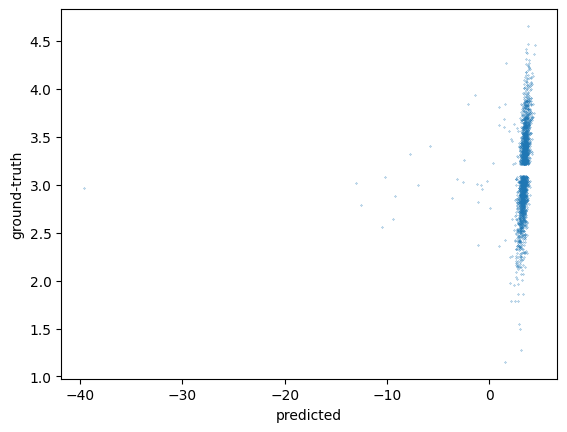

<Figure size 640x480 with 0 Axes>

In [26]:
# ava prediction
y_test = np.array(ava_pred_df.loc[:, 'scaled_MOS_aesthetic'])
y_pred = np.array(ava_pred_df.loc[:, 'pred_mos_aesthetic'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Aesthetic Score Ground truth - Prediction')

SRCC/PLCC/RMSE 0.836/0.713/0.373


Text(0.5, 0.98, 'Aesthetic Score Ground truth - Prediction')

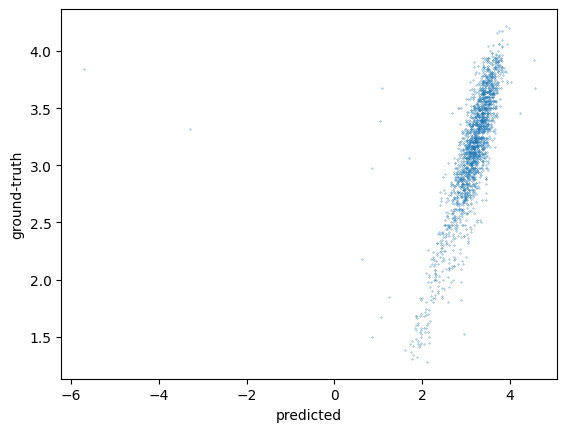

<Figure size 640x480 with 0 Axes>

In [27]:
# para prediction
y_test = np.array(para_pred_df.loc[:, 'scaled_MOS_aesthetic'])
y_pred = np.array(para_pred_df.loc[:, 'pred_mos_aesthetic'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Aesthetic Score Ground truth - Prediction')

SRCC/PLCC/RMSE 0.852/0.669/0.435


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

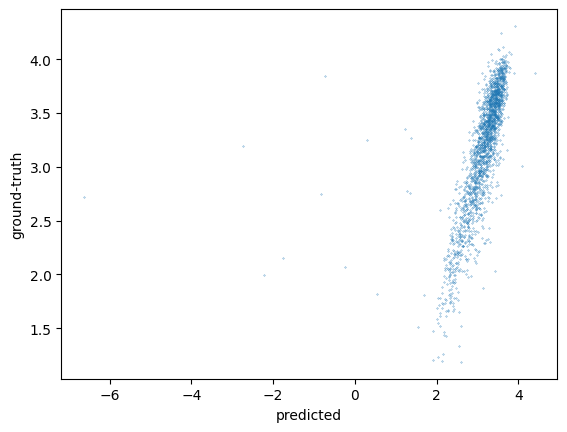

<Figure size 640x480 with 0 Axes>

In [28]:
# koniq prediction
y_test = np.array(koniq_pred_df.loc[:, 'scaled_MOS_quality'])
y_pred = np.array(koniq_pred_df.loc[:, 'pred_mos_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

SRCC/PLCC/RMSE 0.767/0.473/0.71


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

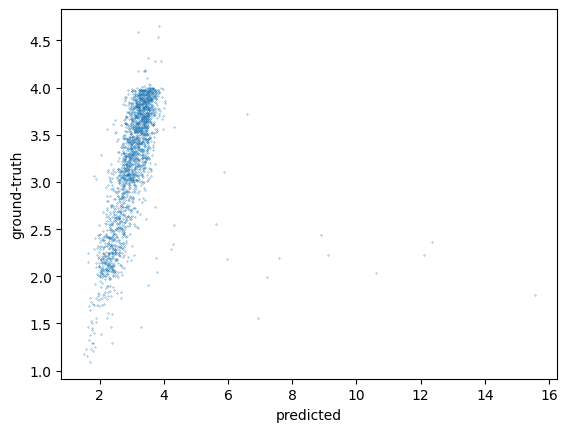

<Figure size 640x480 with 0 Axes>

In [29]:
# ava prediction
y_test = np.array(spaq_pred_df.loc[:, 'scaled_MOS_quality'])
y_pred = np.array(spaq_pred_df.loc[:, 'pred_mos_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [30]:
# save the test_df for prediction later on
ava_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_multimodel_ava.csv')
para_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_multimodel_para.csv')
koniq_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_multimodel_koniq.csv')
spaq_test_df.to_csv(main_directory + 'multimodel_dataset/prediction/predict_multimodel_spaq.csv')